In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import mannwhitneyu, ttest_ind
from dataclasses import dataclass

Цель исследования: рассмотреть подходы для сравнения средних двух выборок, оценить ошибки I и II рода, проверить сонаправленность разности средних и проверяемых гипотез
Сравниваться будут: 
1) t-test Уэлча
2) бакетный t-test Уэлча
3) бакетный тест Манна-Уитни

Проверим как на метриках конверсии, так и на непрерывных метриках. Если результаты на этих данных будут многообещающими, то проверим на метриках отношений.

Проверка будет произведена на 100, 10_000 и 1_000_000 наблюдениях

In [ ]:
@dataclass
class StatTestCalc:
    n: int
    n_bucket: int
    distribution: str  # 'normal', 'exp', ...
    p: float = None
    mean: float = None
    std: float = None

    '''
    n: кол-во наблюдений
    n_bucket: число бакетов на все наблюдения
    distribution: распределение выборки
    mean: среднее значение выборки
    sqrt: стандартное отклонение выборки
    '''

    def gen_dist(self) -> pd.DataFrame:
        if self.distribution == 'normal':
            if self.mean is None or self.std is None:
                raise ValueError("укажите mean и std для нормального распределения")
            data = np.random.normal(self.mean, self.std, size=self.n)

        elif self.distribution == 'exp':
            if self.mean is None:
                raise ValueError("укажите mean для экспоненциального распределения")
            data = np.random.exponential(scale=self.mean, size=self.n)

        else:
                raise ValueError(f"Unknown distribution: {self.distribution}")
        df = pd.DataFrame({'gmv': data})
        df['gmv'] = df['gmv'].apply(lambda x: 0 if x < 30 else x)
        df['cr'] = df['gmv'].apply(lambda x: x > 0)
        return df

    def get_group(self, df) -> pd.DataFrame:
        df['ab_group'] = df.apply(lambda x: np.random.choice(['a', 'b'], p=[0.5, 0.5]), axis=1)
        return df
    
    def get_bucket(self, df) -> pd.DataFrame:
        df['bucket'] = df.apply(lambda x: np.random.choice(np.arange(0, self.n_bucket)), axis=1)
        return df
    
    def collect_stats(self, df, metric) -> dict:
        a_df = df[df['ab_group'] == 'a']
        b_df = df[df['ab_group'] == 'b']

        a_buckets = a_df.groupby('bucket', as_index=False).agg(mean_buck=(metric, 'mean'))
        b_buckets = b_df.groupby('bucket', as_index=False).agg(mean_buck=(metric, 'mean'))

        diff_abs = b_df[metric].mean() - a_df[metric].mean()
        diff_rel = (b_df[metric].mean() - a_df[metric].mean()) / a_df[metric].mean()

        diff_abs_bucket = b_buckets['mean_buck'].mean() - a_buckets['mean_buck'].mean()
        diff_rel_bucket = (b_buckets['mean_buck'].mean() - a_buckets['mean_buck'].mean()) / a_buckets['mean_buck'].mean()

        pval_ttest = ttest_ind(a=a_df[metric],
                               b=b_df[metric],
                               equal_var=False,
                               alternative="two-sided"
                               )[1]
        pval_ttest_bucket = ttest_ind(a=a_buckets['mean_buck'],
                                      b=b_buckets['mean_buck'],
                                      equal_var=False,
                                      alternative="two-sided"
                                    )[1]
        pval_mw = mannwhitneyu(x=a_buckets['mean_buck'],
                               y=b_buckets['mean_buck'],
                               alternative="two-sided")[1]
        
        return {'diff_abs': diff_abs,
                'diff_rel': diff_rel,
                'pval_ttest': pval_ttest,
                'diff_abs_bucket': diff_abs_bucket,
                'diff_rel_bucket': diff_rel_bucket,
                'pval_ttest_bucket': pval_ttest_bucket,
                'pval_mw_bucket': pval_mw
                }
    

    def plot_stats(self, df, metric, n, alpha=0.05):

        sns.set(style="whitegrid", font_scale=1.2)

        fig, axes = plt.subplots(3, 3, figsize=(18, 12))
        fig.suptitle(f'Метрика {metric}, число итераций {n}, число наблюдений {self.n}, число бакетов {self.n_bucket}', fontsize=22)

        fpr_ttest = round((df['pval_ttest'] < alpha).mean(), 3)
        fpr_ttest_b = round((df['pval_ttest_bucket'] < alpha).mean(), 3)
        fpr_mw_b = round((df['pval_mw_bucket'] < alpha).mean(), 3)

        sns.histplot(ax=axes[0, 0], x=df['pval_ttest'], stat='probability', bins=20)
        axes[0, 0].set_xlabel('p-value t-test', fontsize=14)
        axes[0, 0].set_title(f't-test, FPR={fpr_ttest}', fontsize=18)

        sns.histplot(ax=axes[0, 1], x=df['pval_ttest_bucket'], stat='probability', bins=20)
        axes[0, 1].set_xlabel('p-value t-test_bucket', fontsize=14)
        axes[0, 1].set_title(f'бакетный t-test, FPR={fpr_ttest_b}', fontsize=18)

        sns.histplot(ax=axes[0, 2], x=df['pval_mw_bucket'], stat='probability', bins=20)
        axes[0, 2].set_xlabel('p-value mw_bucket', fontsize=14)
        axes[0, 2].set_title(f'бакетный MW, FPR={fpr_mw_b}', fontsize=18)

        sns.scatterplot(ax=axes[1, 0], x=df['pval_ttest'], y=df['pval_ttest_bucket'])
        axes[1, 0].set_xlabel('t-test', fontsize=13)
        axes[1, 0].set_ylabel('t-test_bucket', fontsize=13)
        axes[1, 0].set_title('Сравнение: t-test vs bucket', fontsize=17)

        sns.scatterplot(ax=axes[1, 1], x=df['pval_ttest'], y=df['pval_mw_bucket'])
        axes[1, 1].set_xlabel('t-test', fontsize=13)
        axes[1, 1].set_ylabel('mw_bucket', fontsize=13)
        axes[1, 1].set_title('Сравнение: t-test vs bucket MW', fontsize=17)

        sns.scatterplot(ax=axes[1, 2], x=df['pval_mw_bucket'], y=df['pval_ttest_bucket'])
        axes[1, 2].set_xlabel('mw_bucket', fontsize=13)
        axes[1, 2].set_ylabel('t-test_bucket', fontsize=13)
        axes[1, 2].set_title('Сравнение: bucket MW vs bucket t-test', fontsize=17)

        sns.scatterplot(ax=axes[2, 0], x=df['diff_rel'], y=df['diff_rel_bucket'])
        axes[2, 0].set_xlabel('diff_rel', fontsize=13)
        axes[2, 0].set_ylabel('diff_rel_bucket', fontsize=13)
        axes[2, 0].set_title('Относительный эффект: обычный и бакетный', fontsize=17)

        sns.scatterplot(ax=axes[2, 1], x=df['diff_abs'], y=df['diff_abs_bucket'])
        axes[2, 1].set_xlabel('diff_abs', fontsize=13)
        axes[2, 1].set_ylabel('diff_abs_bucket', fontsize=13)
        axes[2, 1].set_title('Абсолютный эффект: обычный и бакетный', fontsize=17)

        axes[2, 2].axis('off')
        plt.tight_layout(rect=[0, 0, 1, 0.95])

In [104]:
test_calc = StatTestCalc(n=100, n_bucket=10, distribution='exp', mean=500)
df = test_calc.gen_dist()

results = []
for _ in tqdm(range(1_000)):
    df = test_calc.get_group(df)
    df = test_calc.get_bucket(df)
    results.append(test_calc.collect_stats(df, 'gmv'))
df_results = pd.DataFrame(results)

100%|██████████| 1000/1000 [00:17<00:00, 55.58it/s]


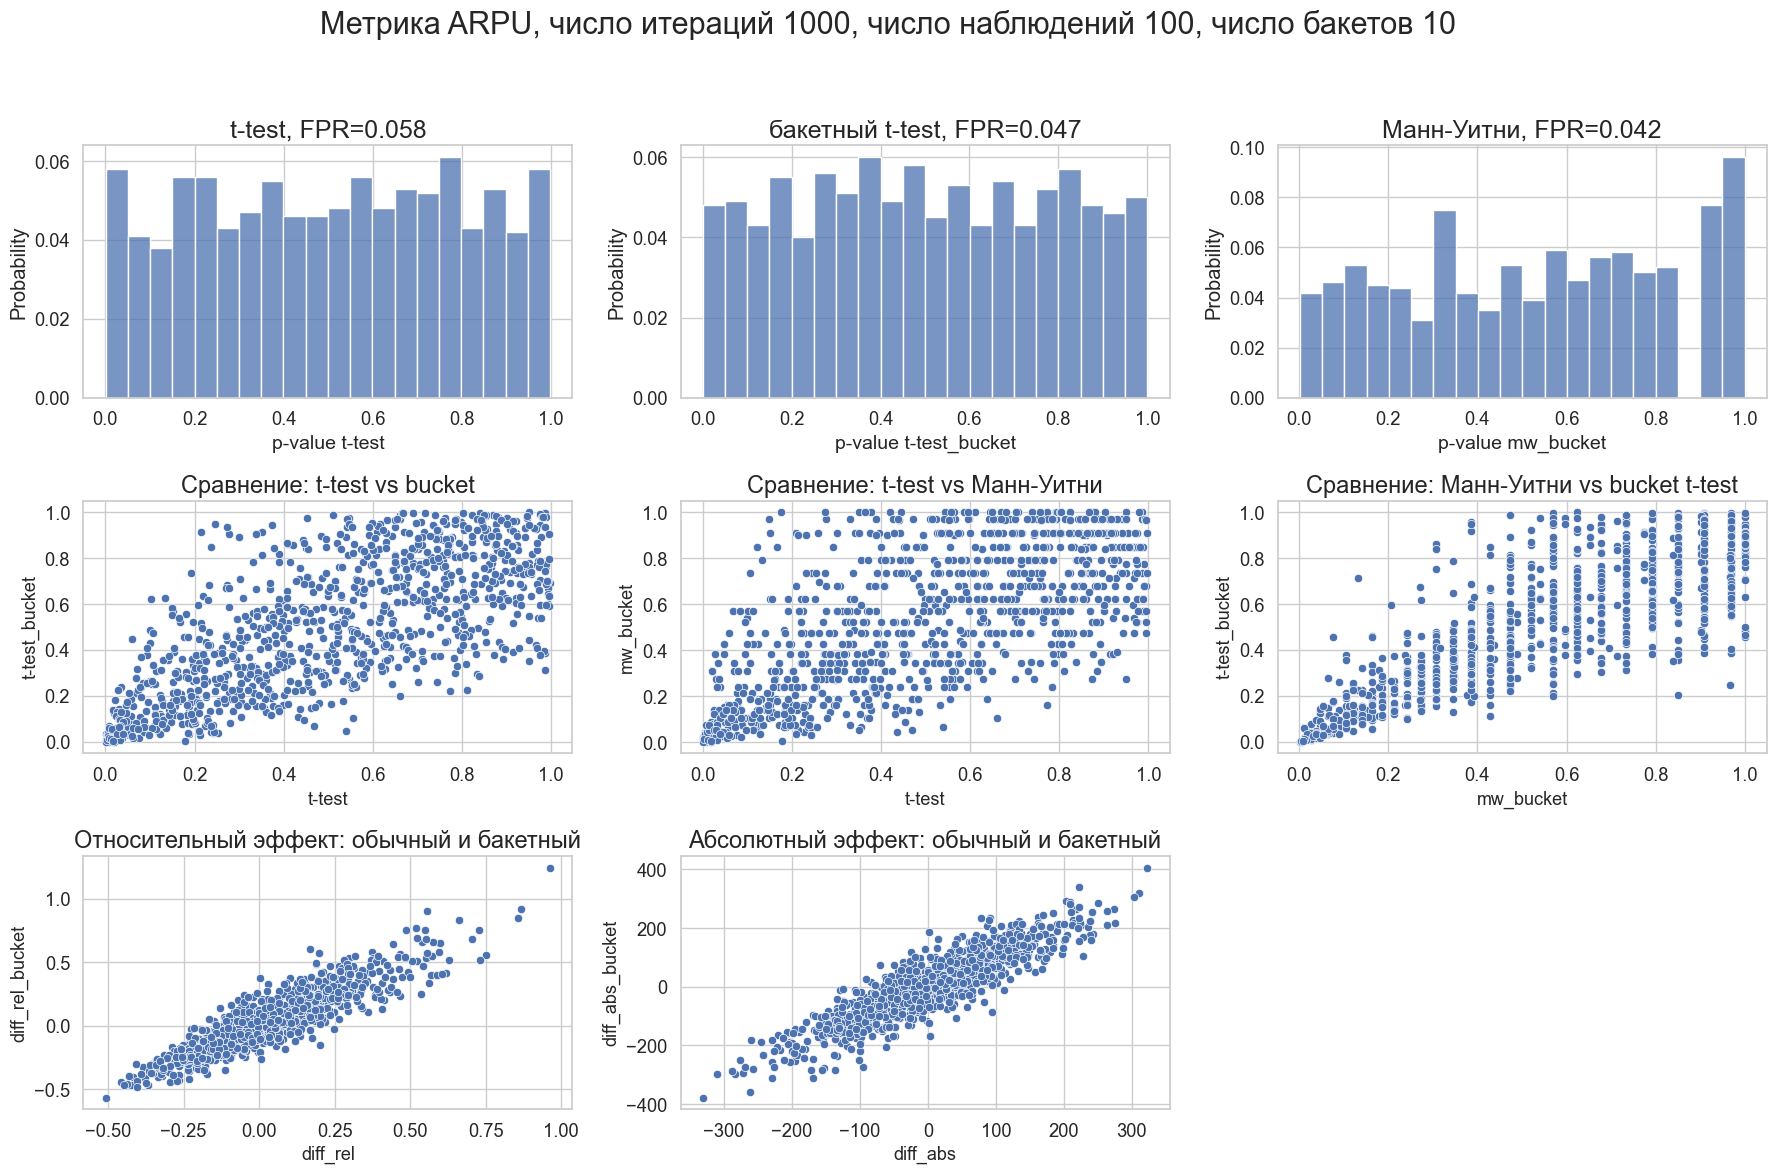

In [105]:
test_calc.plot_stats(df=df_results, metric='ARPU', n=1000)

100%|██████████| 1000/1000 [07:35<00:00,  2.19it/s]


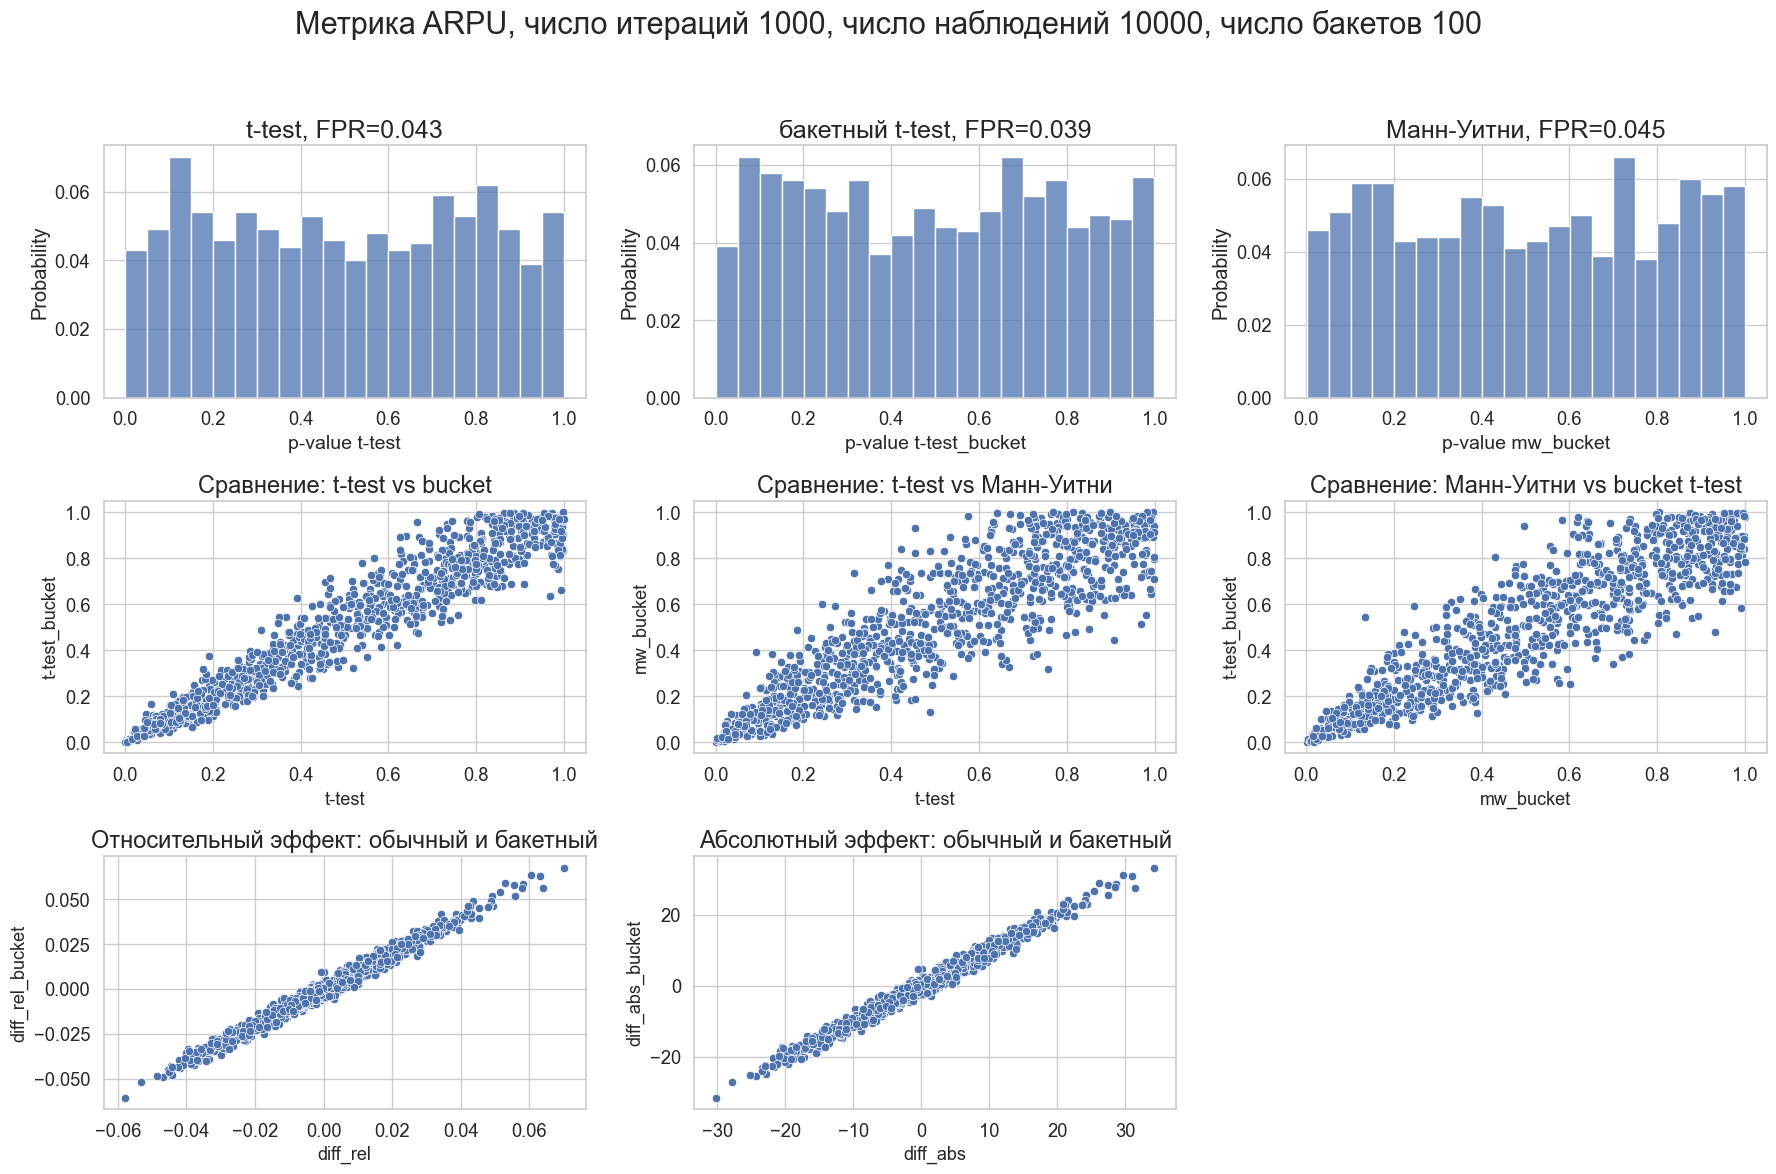

In [106]:
test_calc = StatTestCalc(n=10_000, n_bucket=100, distribution='exp', mean=500)
df = test_calc.gen_dist()

results = []
for _ in tqdm(range(1_000)):
    df = test_calc.get_group(df)
    df = test_calc.get_bucket(df)
    results.append(test_calc.collect_stats(df, 'gmv'))
df_results = pd.DataFrame(results)

test_calc.plot_stats(df=df_results, metric='ARPU', n=1000)

In [108]:
test_calc = StatTestCalc(n=100_000, n_bucket=100, distribution='exp', mean=500)
df = test_calc.gen_dist()

results = []
for _ in tqdm(range(1_000)):
    df = test_calc.get_group(df)
    df = test_calc.get_bucket(df)
    results.append(test_calc.collect_stats(df, 'gmv'))
df_results = pd.DataFrame(results)

test_calc.plot_stats(df=df_results, metric='ARPU', n=1000)

  4%|▍         | 42/1000 [03:08<1:11:39,  4.49s/it]


KeyboardInterrupt: 